# Regresní model pro reakční dobu

Budeme zkoumat závislost reakční doby na některých fyzických
charakteristikách příslušníků policie.

## Příprava a prozkoumání dat

Začneme importy a některými nastaveními.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import patsy as pa
import seaborn as sns
import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)

react = 'react'

Dále načteme data.

In [2]:
df = pd.read_csv('police.txt', delimiter='[ \t]+', engine='python')
df['react'] = df['react']*1000

Pro získání základního přehledu o datech se můžeme kouknout na jednak na
samotnou datovou matici, dále pak na párové scatter ploty a heatmapu korelací.

In [3]:
df

,react,height,weight,fat,pulse,diast
0,310.0,179.6,74.20,11.91,64,64
1,345.0,175.6,62.04,3.13,88,78
2,293.0,166.2,72.96,16.89,100,88
3,254.0,173.8,85.92,19.59,64,62
4,384.0,184.8,65.88,7.74,80,68
5,406.0,189.1,102.26,30.42,60,68
6,344.0,191.5,84.04,13.70,64,48
7,321.0,180.2,68.34,3.04,74,64
8,425.0,193.8,95.14,20.26,80,78
9,385.0,163.1,54.28,3.04,84,78


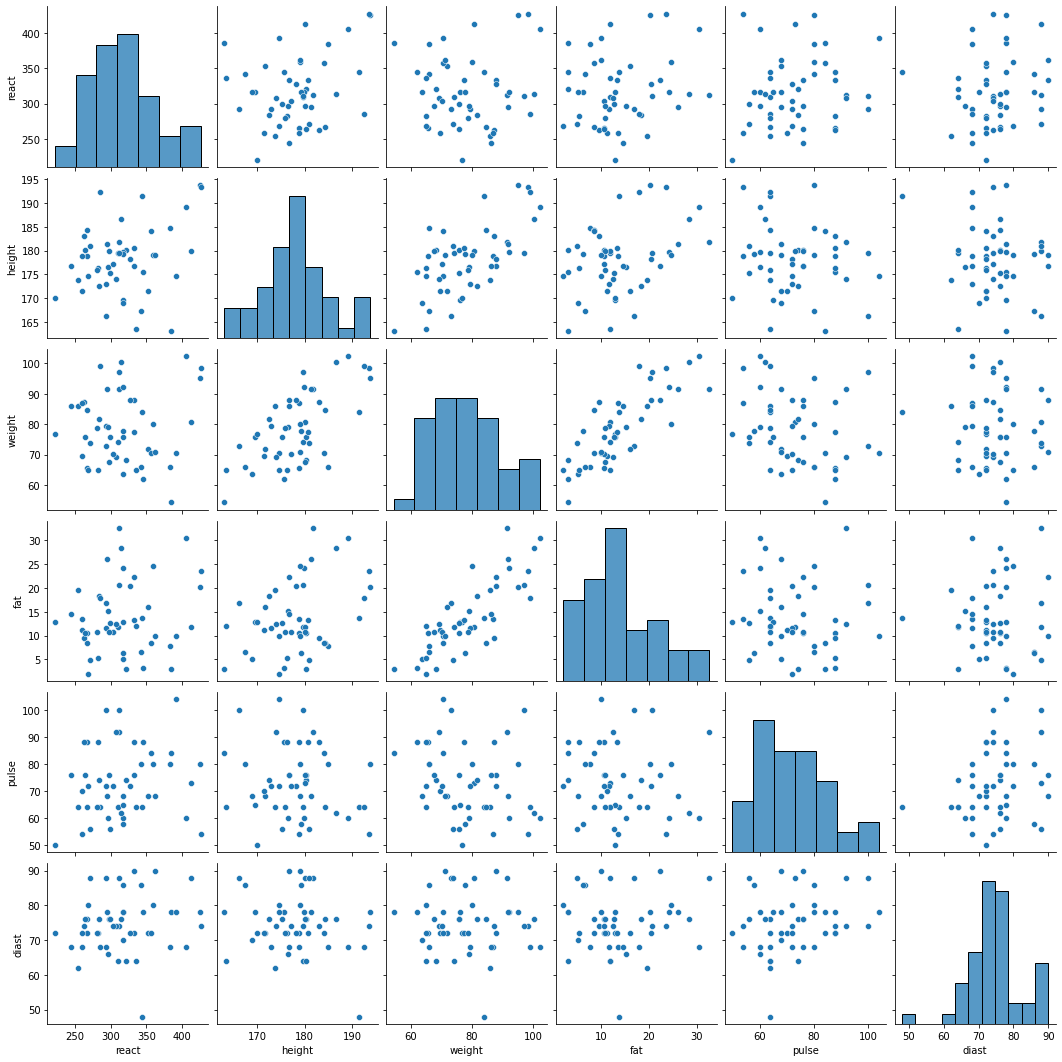

In [4]:
sns.pairplot(df);


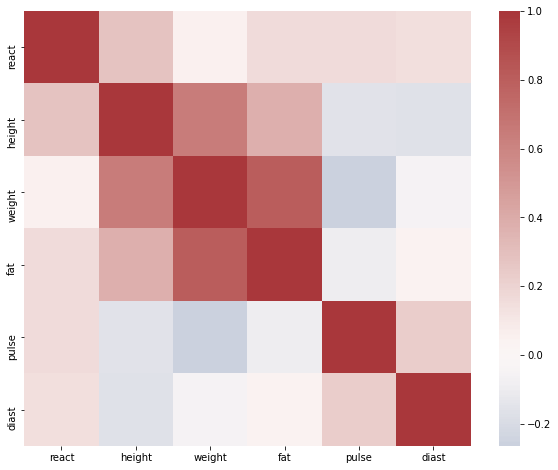

In [5]:
sns.heatmap(
    df.corr(),
    cmap=sns.color_palette('vlag', as_cmap=True),
    center=0
);

Dále prozkoumejme závislost odezvy na jednotlivých prediktorech.

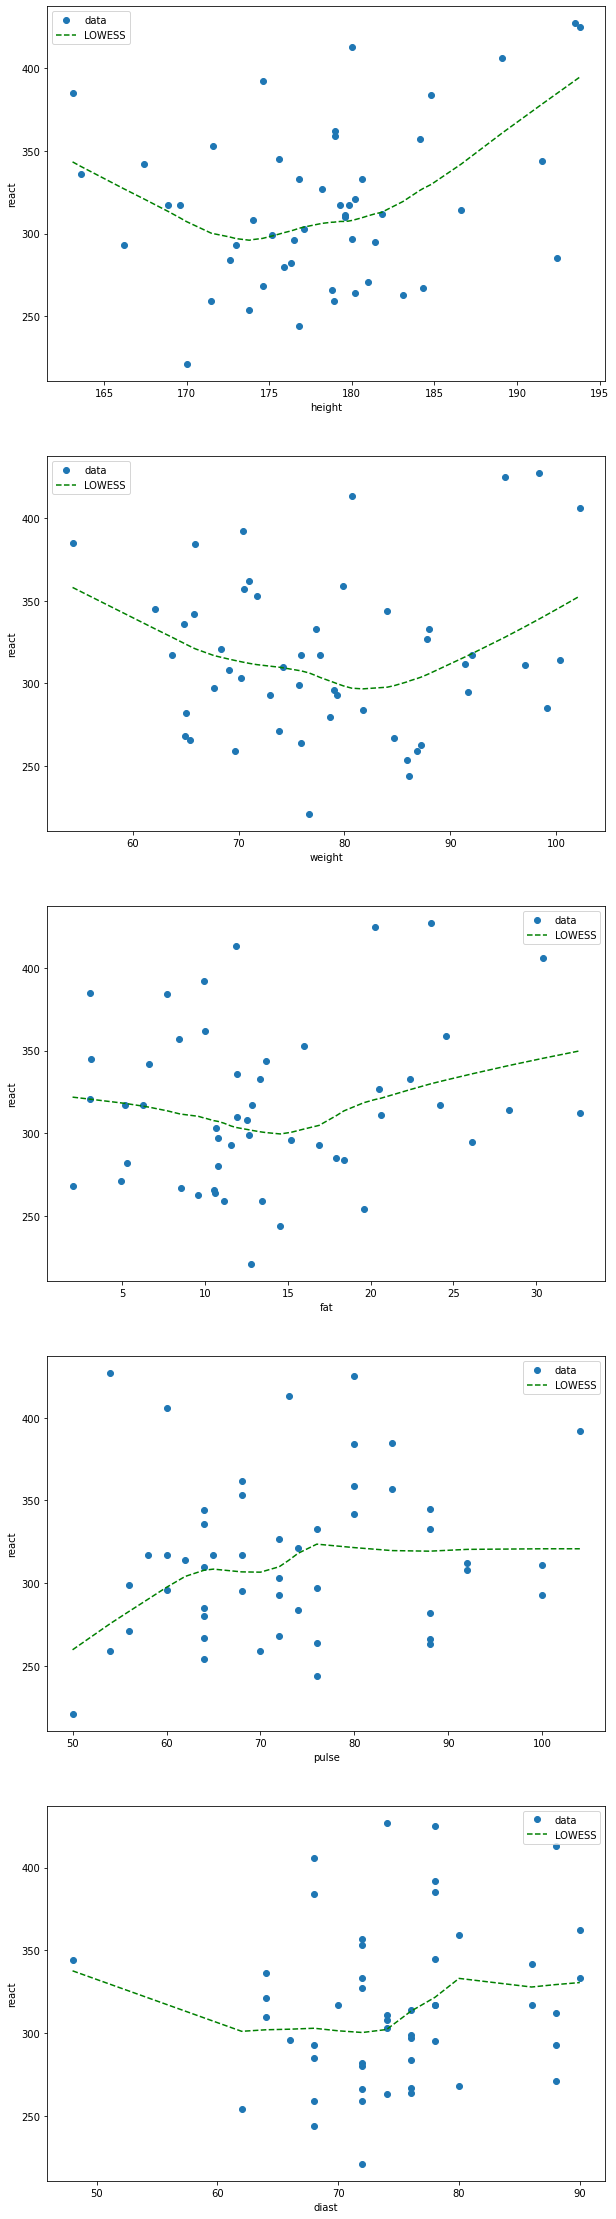

In [6]:
y = df['react']

predictors = list(df.columns)
predictors.remove(react)

preds_lowess = []

for pred in predictors:
    pred_lowess = sm.nonparametric.lowess(y, df[pred])
    preds_lowess.append(pred_lowess)

_, axes = plt.subplots(len(predictors), 1, figsize=(10, len(predictors)*8))

for idx, pred in enumerate(predictors):
    ax = axes[idx]
    lowess = preds_lowess[idx]

    ax.plot(df[pred], y, 'o', label='data')
    ax.plot(lowess[:,0], lowess[:,1], 'g--', label='LOWESS')
    ax.set_xlabel(pred)
    ax.set_ylabel(react)
    ax.legend(loc='best')

## Tvorba modelu

Na základě LOWESS křívek se můžeme domnívat, že vztah mezi výškou, vahou a
reakční dobou je dán parabolou. Asi nás nepřekvapí, že vztahy jsou podobné,
protože víme, že váha a výška jsou úzce spojené.
Zajímavé je, že u podílu tuku už takto výraznou závislost nepozorujeme,
přesto pořád bychom hádali opět spíše parabolu, možná přímku.
Lidé s nižším pulsem si vedli o něco lépe, vztah přípomíná logaritmus, možná
odmocninu.
Logaritmu bych věřil o něco více, protože ve vyšších hodnotách pulsu je
růst velmi pozvolný.
Tlak má poněkud záhadnou závislost.
Úvodnímu zlomu moc nemůžeme věřit, protože je způsobem jediným netypickým
pozorováním.
Ovšem těžko se jednoduše popisuje další tvar.
Abychom udrželi věci jednoduché, řekněme, že použijeme přímku.
Použijeme tedy tento model.

Zkoušel jsem řadu jiných možností včetně uvedení BMI, které by dohromady
shrnulo podobné veličiny výšky, váhy a podílu tuku (nepřímo zahrnutý přes váhu).
Ovšem zdaleka jsem neměl tak dobré výsledky a nerad bych zaplevelit tento
report různými neúspěšnými přístupy, když je zaměřen na něco jiného.

Abychom snižili číslo podmíněnosti, tak vycentrujeme všechny hodnoty až na
puls.
U jeho škálování bychom měli být opatrnější, protože tím změníme model (u
ostatních hodnot ne, protože se rozdíl dorovná interceptem, případně
lineárním členem).

In [7]:
df_orig = df.copy()
df[['height', 'weight', 'fat', 'diast']] = \
    df[['height', 'weight', 'fat', 'diast']] \
    - df[['height', 'weight', 'fat', 'diast']].mean()

In [8]:
y, X = pa.dmatrices('react '
                    '~ height + I(height**2)'
                    '+ weight + I(weight**2)'
                    '+ fat'
                    '+ np.log(pulse)'
                    '+ diast',
                    data=df,
                    return_type='dataframe')

model_1 = sm.OLS(y, X)
res_1 = model_1.fit()

res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  react   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     4.781
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           0.000508
Time:                        21:45:57   Log-Likelihood:                -249.57
No. Observations:                  50   AIC:                             515.1
Df Residuals:                      42   BIC:                             530.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        188.0111    151.605      1.240      0.222    -117.941     493.963
height             3.7217      1.137      3.274      0.002       1.428       6.016
I(height ** 2)     0.2697      0.097      2.788      0.008       0.075       0.465
weight            -3.0068      1.132     -2.656      0.011      -5.291      -0.722
I(weight ** 2)     0.0285      0.048      0.597      0.553      -0.068       0.125
fat                3.0679      1.419      2.161      0.036       0.203       5.932
np.log(pulse)     26.0663     35.483      0.735      0.467     -45.542      97.675
diast              1.3932      0.726      1.920      0.062      -0.071       2.857
==============================================================================
Omnibus:                        0.267   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.022
Skew:                           0.047   Prob(JB):                        0.989
Kurtosis:                       3.045   Cond. No.                     5.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dále ukažme základní grafy reziduí.

In [9]:
def plot_fitted_values(model_results):
    _, ax = plt.subplots()

    resids_lowess = sm.nonparametric.lowess(model_results.resid_pearson, model_results.fittedvalues)

    ax.plot(model_results.fittedvalues, model_results.resid_pearson, 'o', label='norm resids')
    ax.plot(resids_lowess[:,0], resids_lowess[:,1], 'g--', label='resids LOWESS')
    ax.axhline(0, c='r')
    ax.set_xlabel('Vyrovnané hodnoty')
    ax.legend(loc='best')

def plot_resids_against_predictors(model_results, predictor_names):
    preds_resids_lowess = []

    for pred in predictor_names:
        pred_lowess = sm.nonparametric.lowess(model_results.resid_pearson, df[pred])
        preds_resids_lowess.append(pred_lowess)

    _, axes = plt.subplots(len(predictor_names), 1, figsize=(10, len(predictor_names)*8))

    for idx, pred in enumerate(predictor_names):
        ax = axes[idx]
        lowess = preds_resids_lowess[idx]

        ax.plot(df[pred], model_results.resid_pearson, 'o', label='data')
        ax.plot(lowess[:,0], lowess[:,1], 'g--', label='LOWESS')
        ax.set_xlabel(pred)
        ax.set_ylabel(react)
        ax.axhline(0, c='r')
        ax.legend(loc="best")

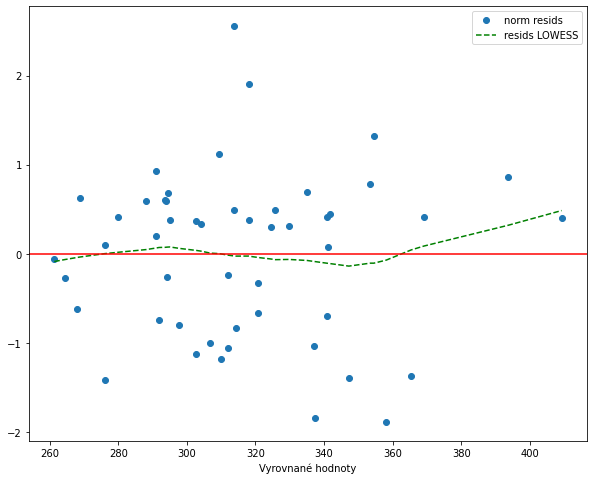

In [10]:
plot_fitted_values(res_1)

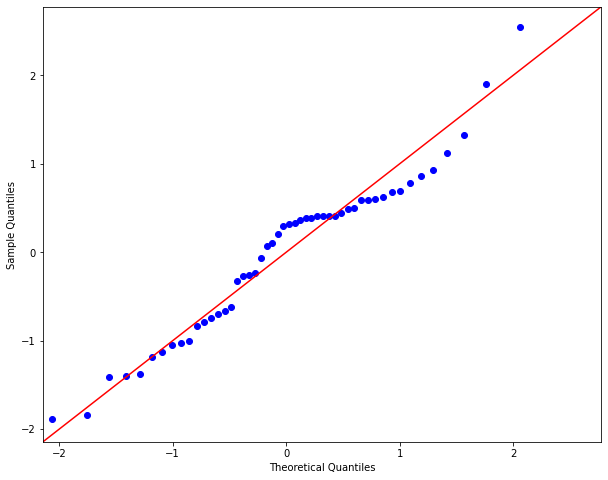

In [11]:
sm.graphics.qqplot(res_1.resid_pearson, line='45');

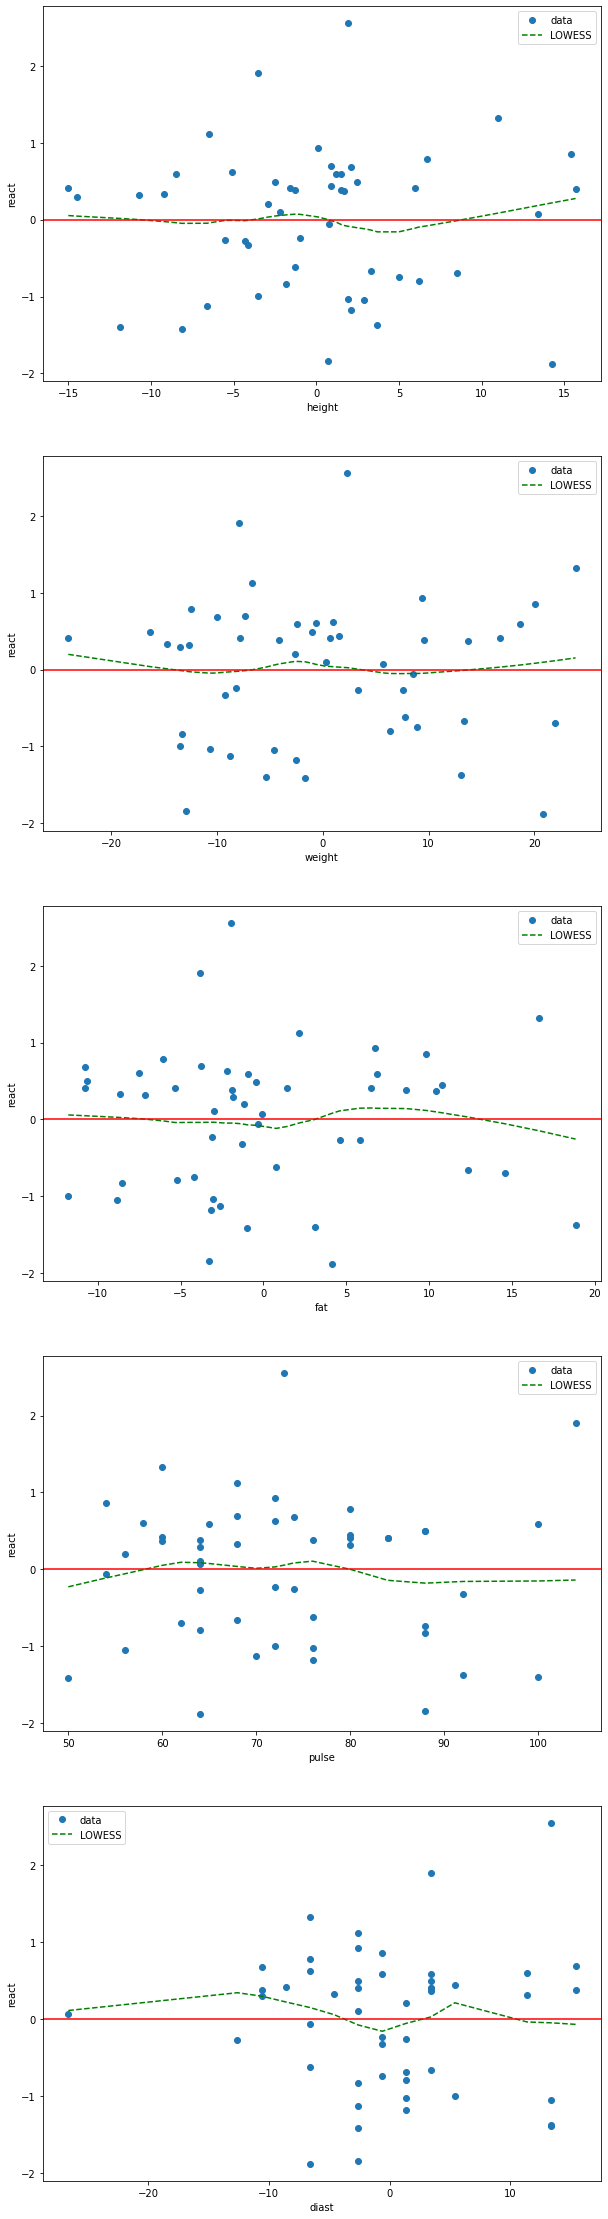

In [12]:
plot_resids_against_predictors(res_1, predictors)

Vidíme, že grafy obecně vypadají docela pěkně, jen snad QQ plot nevypadá moc
předpisově.

Nyní můžeme zkoušet zjednodušovat model odebráním veličin, které v modelu
nejsou dostatečně signifikantní. Začneme odebráním druhé mocniny váhy.

In [13]:
y, X = pa.dmatrices('react '
                    '~ height + I(height**2)'
                    '+ weight'
                    '+ fat'
                    '+ np.log(pulse)'
                    '+ diast',
                    data=df,
                    return_type='dataframe')

model_2 = sm.OLS(y, X)
res_2 = model_2.fit()

res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  react   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     5.602
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           0.000231
Time:                        21:45:58   Log-Likelihood:                -249.79
No. Observations:                  50   AIC:                             513.6
Df Residuals:                      43   BIC:                             527.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        175.2936    148.977      1.177      0.246    -125.146     475.734
height             3.8067      1.119      3.401      0.001       1.549       6.064
I(height ** 2)     0.3023      0.079      3.811      0.000       0.142       0.462
weight            -2.9923      1.123     -2.664      0.011      -5.258      -0.727
fat                3.1481      1.402      2.245      0.030       0.320       5.976
np.log(pulse)     29.5307     34.744      0.850      0.400     -40.536      99.598
diast              1.4197      0.719      1.975      0.055      -0.030       2.869
==============================================================================
Omnibus:                        0.106   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.025
Skew:                           0.041   Prob(JB):                        0.988
Kurtosis:                       2.927   Cond. No.                     2.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

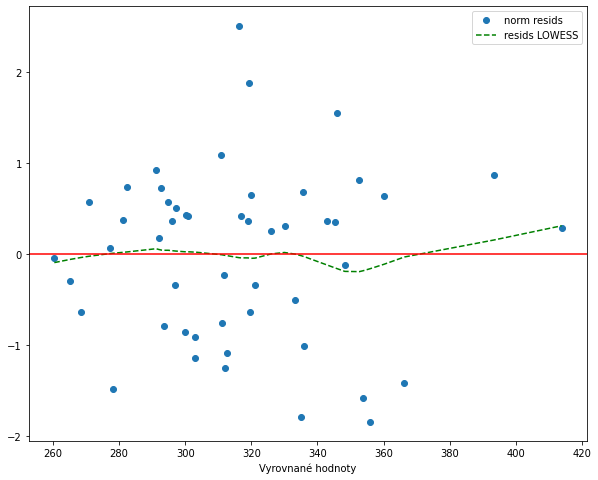

In [14]:
plot_fitted_values(res_2)

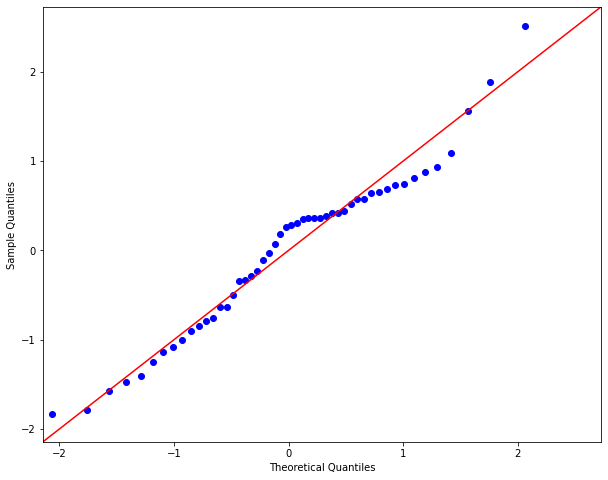

In [15]:
sm.graphics.qqplot(res_2.resid_pearson, line='45');

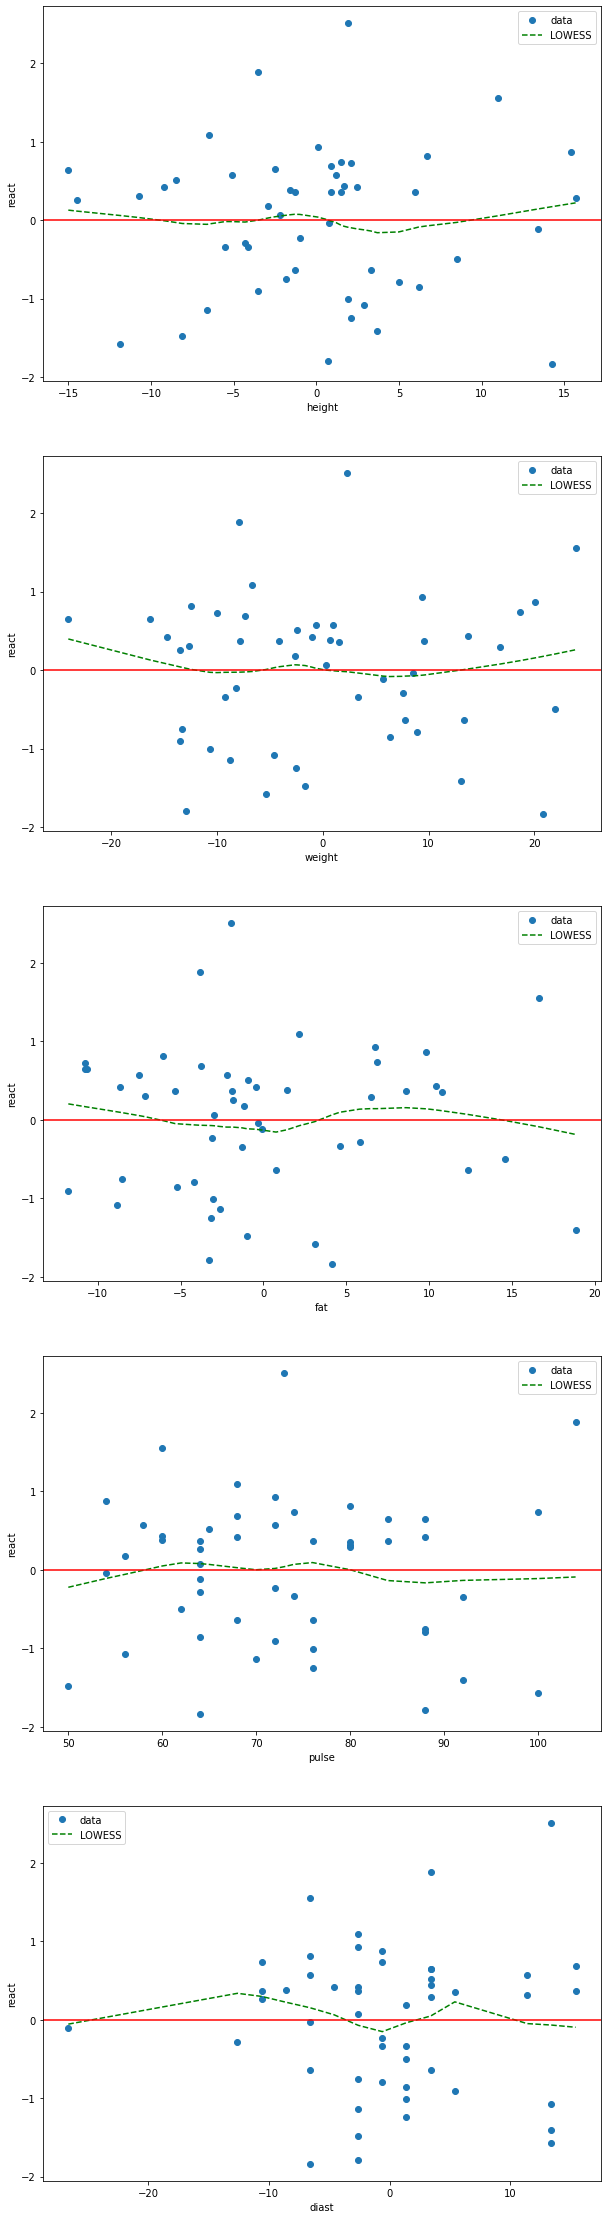

In [16]:
plot_resids_against_predictors(res_2, predictors)

Vlastnosti modelu se změnily minimálně, některé jako například $R_{adj}^2$ se
dokonce zlepšily.
Zaštíněni poučkou, že jednodušší model je lepší model, můžeme v odebírání
pokračovat odebráním vlivu pulsu.

In [17]:
predictors.remove('pulse')

y, X = pa.dmatrices('react '
                    '~ height + I(height**2)'
                    '+ weight'
                    '+ fat'
                    '+ diast',
                    data=df,
                    return_type='dataframe')

model_3 = sm.OLS(y, X)
res_3 = model_3.fit()

res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  react   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     6.619
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           0.000113
Time:                        21:45:59   Log-Likelihood:                -250.20
No. Observations:                  50   AIC:                             512.4
Df Residuals:                      44   BIC:                             523.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        301.7913      6.641     45.443      0.000     288.407     315.175
height             3.9503      1.103      3.581      0.001       1.727       6.173
I(height ** 2)     0.2980      0.079      3.777      0.000       0.139       0.457
weight            -3.3078      1.057     -3.130      0.003      -5.438      -1.178
fat                3.4199      1.361      2.512      0.016       0.677       6.163
diast              1.5420      0.702      2.196      0.033       0.127       2.957
==============================================================================
Omnibus:                        0.302   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.102
Skew:                           0.110   Prob(JB):                        0.950
Kurtosis:                       2.999   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

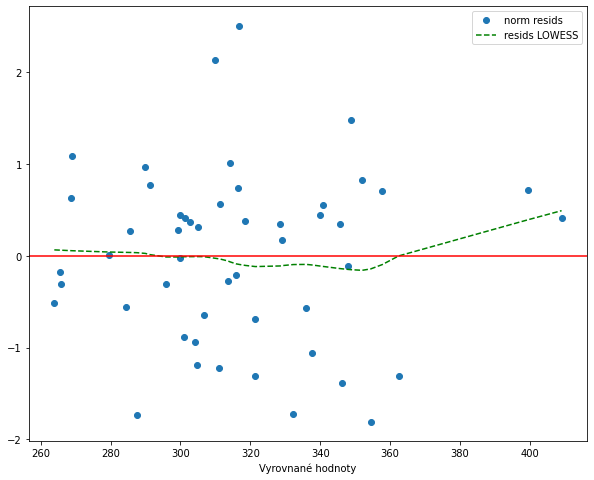

In [18]:
plot_fitted_values(res_3)

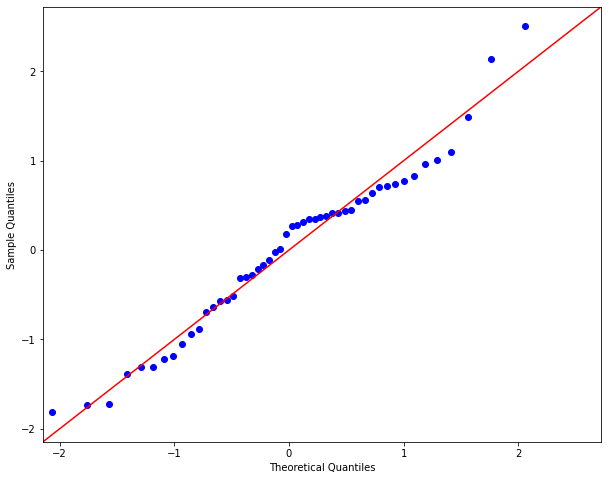

In [19]:
sm.graphics.qqplot(res_3.resid_pearson, line='45');

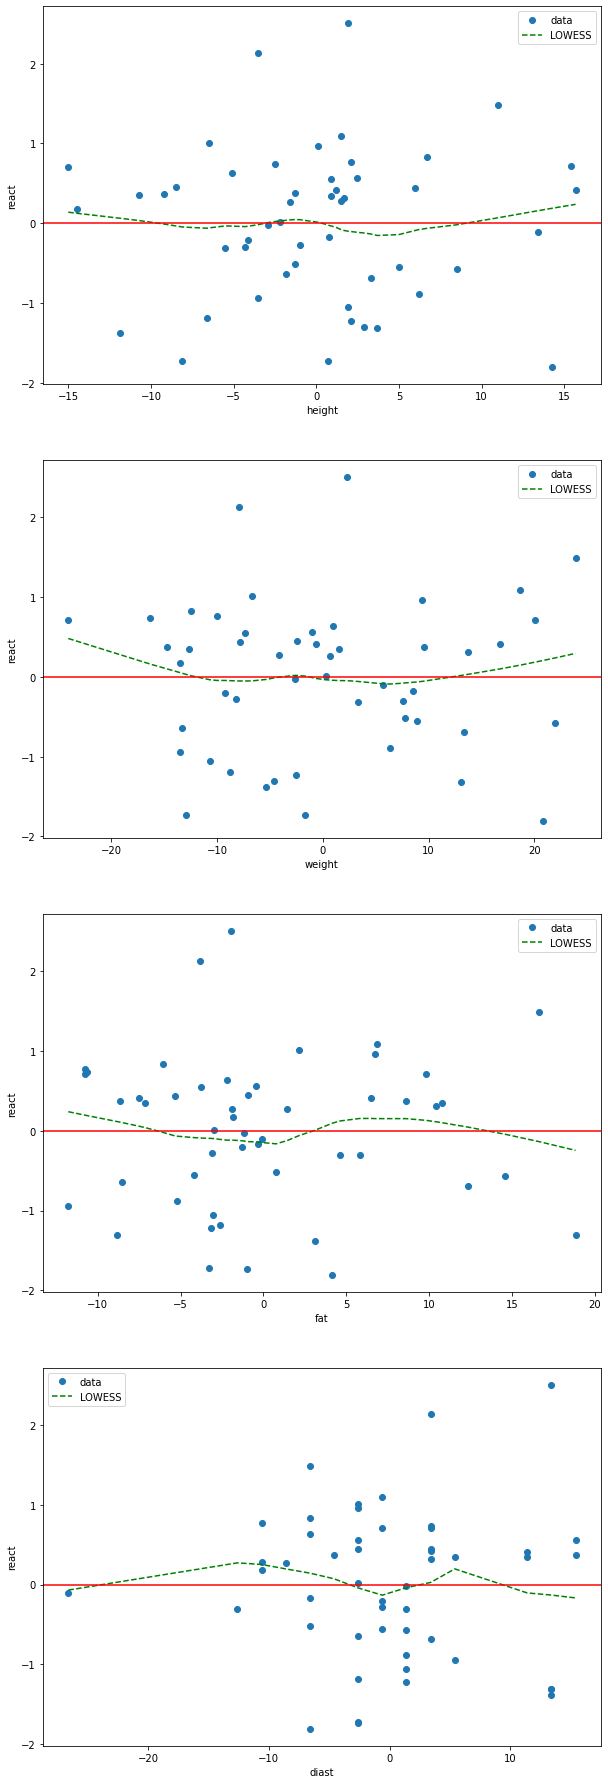

In [20]:
plot_resids_against_predictors(res_3, predictors)

Ani další zjednodušení modelu neuškodilo.
Konečně jsme se zbavili hlášení o špatném čísle podmíněnosti,
opět nám o něco stoupla hodnota upravený koeficient determinace a F
statistiky, která testuje
hypotézu, že odezva nezávisí na žádném z prediktorů a především je nyní každá
transformace významná pro odhad (p-hodnoty jsou pod 0.05).
Dokonce mi přijde, že i QQ plot je o něco hezčí.

S tímto modelem tedy můžeme být pro tuto chvíli spokojeni a můžeme začít
zkoumat jeho další vlastnosti.

## Další vlastnosti modelu

V zadání se požaduje prozkoumat odlehlá a vlivná pozorování. Oba typy můžeme
snadno nalézt z tzv. influence plotu.

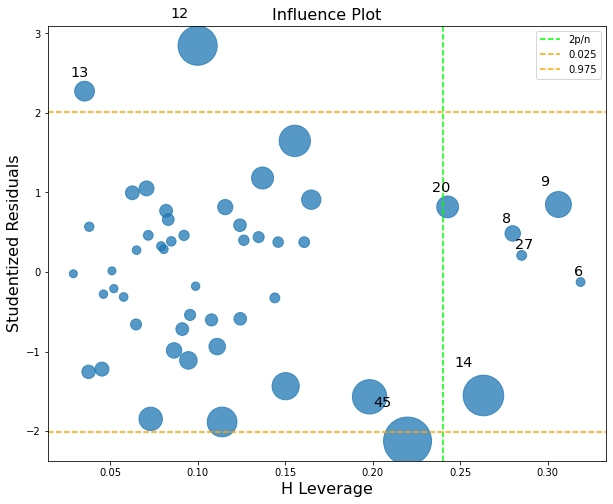

In [21]:
_, ax = plt.subplots()
from scipy import stats

quantile = stats.t.ppf(0.975, res_3.df_resid)

sm.graphics.influence_plot(res_3, ax=ax)
ax.axvline(x=2*6/len(df), ls='--', c='lime', label='2p/n')
ax.axhline(y=-quantile, ls='--', c='orange', label='0.025')
ax.axhline(y=quantile, ls='--', c='orange', label='0.975')
ax.legend();

V tomto grafu jsou obecně podezřelá pozorování označena svým indexem v datové
matici.
Pozorování je podezřelé, pokud má velké reziduum nebo pokud má velký vliv,
což je posuzováno pomocí charakteristiky leverage.
Vedle toho je velikost bodu dána Cookovou vzdáleností, která je kombinací
obou předchozích.

Reziduum je považováno za příliš velké, pokud v absolutní překročí 0.975
kvantil Studentova rozdělení se stupněm volnosti odpovídajícím reziduálnímu
stupni volnosti (v našem případě 44 = 50 - 5 - 1), což je zhruba 2.
Hodnota leverage je označena za příliš velkou, pokud je větší než 2p/n, kde p
je počet sloupců designové matice a n je počet pozorování.

Hranice "podezřelých oblastí" jsou na grafu taktéž vyznačeny.

Můžeme se pak podívat, jak vypadají podezřelé body.

In [22]:
outliers_indices = [12, 13, 45]
influence_observations_indices = [6, 8, 9, 14, 20, 27]

In [23]:
df_orig.iloc[outliers_indices]

,react,height,weight,fat,pulse,diast
12,413.0,180.0,80.68,11.86,73,88
13,392.0,174.6,70.40,9.93,104,78
45,285.0,192.4,99.14,17.94,64,68


In [24]:
df_orig.iloc[influence_observations_indices]

,react,height,weight,fat,pulse,diast
6,344.0,191.5,84.04,13.70,64,48
8,425.0,193.8,95.14,20.26,80,78
9,385.0,163.1,54.28,3.04,84,78
14,312.0,181.8,91.40,32.63,92,88
20,427.0,193.5,98.44,23.63,54,74
27,336.0,163.6,64.86,11.93,64,64


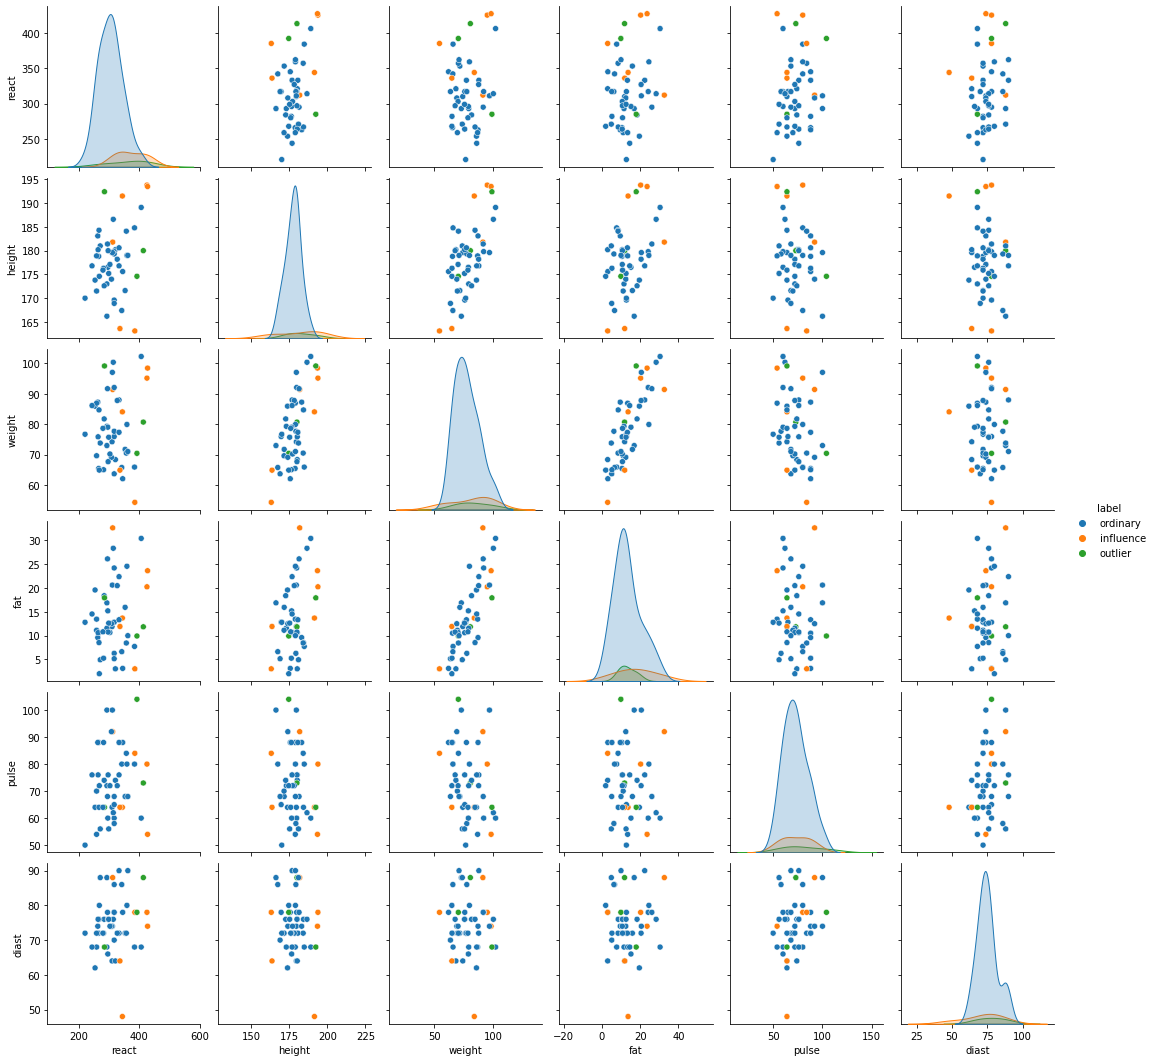

In [25]:
labels = ['influence' if idx in influence_observations_indices
          else ('outlier' if idx in outliers_indices
            else 'ordinary')
          for idx in range(len(df_orig))]

df_orig['label'] = labels
sns.pairplot(df_orig, hue='label');

Když si v pairplotu speciálně vyznačíme obě význačné skupiny bodů, tak
vidíme, že se skutečně tak trochu vymykají a z mnohých úhlů pohledu jde o
výjimečná pozorování.
Vlivná pozorování jsou často zvláštní extrémní výškou a vahou, či jeden bod je
naprosto unikátní v hodnotě tlaku.
Odlehlá pozorování vyčnívají (vzhledem k podobným bodům) svou rychlostí
reakce.

## Vyhodnocení a interpretace modelu

Hodnotit budeme nejjednodušší a nejspíše nejlepší z našich modelů, tedy model
třetí.

### Regresní koeficienty

Z výstupu vidíme, že každý z transformovaných prediktorů má statisticky
signifikantní vliv na reakční dobu (p-hodnota je menší než 0.05).
Tedy každá použitá vysvětlující proměnná má signifikantní vliv.
Naopak tento vliv nemůžeme prokázat u pulsu (který je přidán v modelu 2),
protože p-hodnota je příliš vysoká a konfidenční interval tedy pokrývá 0.

Vzhledem k tomu, že jsme všechny použité hodnoty vycentrovali, tj. odečetli
jejich průměr, je při interpretaci dobré tento původní průměr znát.

In [26]:
df_orig.mean()

react     316.2000
height    178.1060
weight     78.3524
fat        13.7824
pulse      73.0800
diast      74.6000
dtype: float64

Intercept odhaduje pozorování, které má ostatní prediktory nulové, což nastává,
pokud je daná osoba "průměrná".
Tedy měří ~178 cm, váží ~78 kg, podíl tuku má ~13.8 % a tlak má 74.6.
Pak odhadujeme, že jeho reakční čas bude 302 ms.
Konfidenční interval se spolehlivostí 95 % je (288, 315) ms.
Dále už jednotlivé konfidenční intervaly uvádět nebudeme, protože čísla jsou
v tabulce a jejich interpretace se nemění.

Interpretace výšky je složitější, protože se vyskytuje jak v první, tak v
druhé mocnině.
Příspěvek výšky se dá popsat kvadratickou rovnici $4 \cdot Výška + 0.3 \cdot
Výška^2$, ve které samozřejmě mluvíme o již centrované výšce.
Průsečíky s osou x jsou v bodech -13.33 a 0.
Tedy pro osoby s výškou ~164.66 a ~178 cm žádný příspěvek nepozorujeme.
U osob s výškou mezi těmito hodnotami příspívá výška se rychlost reakce
pozitivně, tedy reakce je rychlejší.
Naopak je to u osob mimo toto rozmezí.
Nejlepší vliv je pak u osob výšky ~171.33 cm (kde je vrchol paraboly), které
mají reakci rychlejší o 13.33 ms.

Velmi zajímavý je pak vliv váhy a podílu tuku.
Obě závislosti jsou již jen lineární a samostatně je jejich interpretace
vcelku jednoduchá.
Tedy, každé kilo navíc (při zachování ostatních charakteristik) znamená o 3.3
ms horší reakční dobu.
Naopak každé procento podílu tuku v těle (opět při zachování ostatních
charakteristik) znamená zrychlení o 3.4 ms.

Tyto vztahy ovšem vypadají protichůdně, protože by se zdálo, že váha a podíl
tuku jdou ruku v ruce.
Nicméně jsou-li v modelu zahrnuté obě tyto charakteristiky, jejich vztah se
mění.
Můžeme je zkusit pochopit pomocí myšlenkového experimentu s
průměrnou osobou vážící ~78 kg s podílem tuku ~14 %.
Tuk tohoto člověka tvoři 11 kg jeho hmotnosti, ostatní složky těla pak
zbylých 67 kg.
Nyní se koukněme na vztah hmotnosti a podílu tuku a na přírůstku reakční doby.

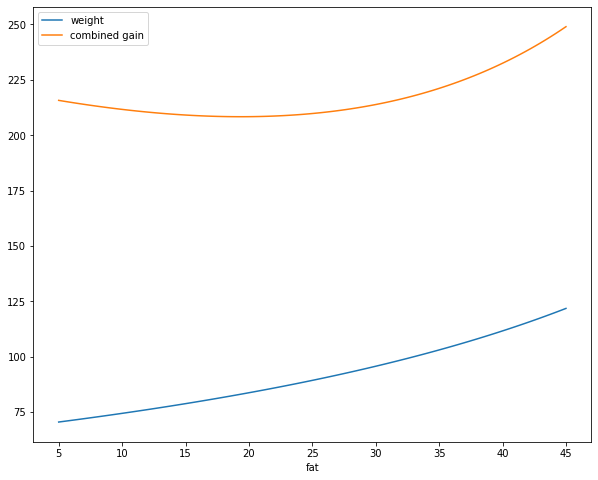

In [27]:
fat_to_weight = lambda fat: 67 / (1-(fat / 100))
gain = lambda fat: -3.4*fat + 3.3*fat_to_weight(fat)

points = np.linspace(5, 45, 100)

_, ax = plt.subplots()

ax.plot(points, [fat_to_weight(f) for f in points], label='weight')
ax.plot(points, [gain(f) for f in points], label='combined gain')
ax.set_xlabel('fat')
ax.legend(loc='best');

Vidíme, že vztah mezi podílem tuku a hmotností není lineární, protože čím
větší už má podíl tuku, tím je těžší a tedy musí přibrat více kilogramů na
získání dalšího procenta tuku.
Z toho pak vyplývá podobný vztah jako pro výšku člověka - nejlepší je rozumný
střed.
Respektive, jak vidíme, příliš málo, či příliš mnoho tuku v těle znamená dle
našeho modelu penalizaci.
To dobře odpovídá rozumnému předpokladu, že zdravý člověk bude mít nejlepší
reakce, přičemž muž má mít 8-20 % tuku v těle, žena pak 18-30 %.
Náš model říká, že osoba, jejíž tělesný "základ" váží 67 kg má mít nejlépe
19,35 % tuku v těle.

Nakonec zakončeme interpretací tlaku.
Ta má očekávanou podobu, tedy zvýšení tlaku o 1 mm Hg, jsou-li ostatní hodnoty
fixované, prodlouží reakční dobu přibližně o 1.5 ms.

### Další charakteristiky modelu

Na výstupu máme tři tabulky, které postupně okomentujeme.

V první máme základní obecné informace o modelu včetně toho, o jaký model
vůbec jde (Ordinary least squares) a kdy byl vytvořen.
Dále, počet pozorování, stupně volnosti residuí a modelu jsou jasné.
Pak máme k dispozici některé další globální charakteristiky modelu jako
koeficient determinace a upravený koeficient determinace, které říkají, jaký
je podíl rozptylu, který lze modelem vysvětlit (tj. oproti triviálnímu modelu
pouze s absolutním členem, který je ekvivalentní odhadu pomocí střední
hodnoty).
Upravený koeficient determinace pak přidává nějakou penalizaci za počet
prediktorů.
Může se tedy stát (a nám se to stalo), že po odebrání proměnné klesne hodnota
$R^2$, ale vzroste hodnota $R_{adj}^2$.
F-statistika testuje hypotézu, že odezva vůbec nezávisí na našich
prediktorech, tedy že všechny koeficienty až na intercept jsou nulové.
Tuto hypotézu samozřejmě zamítáme.
Nakonec v tabulce máme propojené hodnoty log-likelihood, AIC (Akaike
information criterion) a BIC (Bayesian information criterion), které podobně
jako například $R^2$ měří, jak je model dobrý.
Ovšem jde primárně o veličiny používané k porovnávání více modelů mezi sebou a
samotné nemají moc smysl.

Druhá tabulka sdružuje informace o regresních koeficientech.
V jednotlivých sloupcích máme jméno, bodový odhad a odhad směrodatné odchylky.
Dále pak t statistiku testující hypotézu, že příslušný koeficient je nulový.
Z dalšího sloupce s p-hodnotami vidíme, že na hladině významnosti 5 % všechny
tyto hypotézy zamítáme.
Na konci máme uveden konfidenční interval právě s hladinou významnosti 5 %.
Interpretace jednotlivých koeficientů je výše.

Třetí tabulka pak uvádí některé další informace o reziduích.
Většinu z nich nijak důvěrně neznám a jejich popis tedy bude spíše převzatý.
Omnibus měři, zda jsou rezidua normálně rozdělená, přičemž čím menší hodnota,
tím lepší.
Prob(Omnibus) chápeme jako pravděpodobnost, že rozdělení rezuií je normální.
Dále máme skew, česky koeficient šikmosti (samozřejmě výběrový), který měří
asymetrii reziduí.
První sloupec uzavírá kurtosis, česky koeficient špičatosti, který dává
podrobnější informaci o tom, jak jsou hodnoty rozdělené kolem střední hodnoty.
Rozdělení je špičatější, jako v našem případě, pokud je velká část pozorování
blízko střední hodnoty a většina rozptylu vznikla jen kvůli malému podílu
hodnot.
V druhém sloupci začneme statistikou Durbin-Watson, která měří
homoskedasticitu dat a měla by se pohybovat mezi 1 a 2, což v našem modelu
platí.
Jarque-Bera je další test normality, který porovnává šikmost a špičatost
daného rozdělení s normálním rozdělením.
Hodnota 0 znamená perfektní shodu.
Pravděpodobnostně ji vyjadřuje hodnota Prob(JB).
Výstup uzavíráme číslem podmíněnosti, které indikuje citlivost designové
matice na změny hodnot, což značí numerické vlastnosti.
V našem případě není tato hodnota tak vysoká, aby software hlásil problém.
Řekněme tedy, že je v pořádku.

### Splnění předpokladů modelu

Heteroskedasticitu na grafu reziduí nepozorujeme, což dokládá
i Durbinův-Watsonův test.
Normalita pozorování je spornější, což je vidět z QQ plotu.
Také jedna z hodnot ve výstupu modelu, Prob(Omnibus), naznačuje, že normalitu
nemáme.
Naopak Prob(JB) pro ni svědčí.
Subjektivně bych řekl, že daleko od normality nejsme.

Co se týče odlehlých a vlivných pozorování, tak ty jsme diskutovali a nějaké
jsme i našli.
Ovšem například pokud bychom se opřeli o prezentace, ve kterých je podezřelá
leverage od 3p/n výše (na místo 2p/n) a outlier by byl od |std_res| > 3 (jak
jsou brány v knize Statistická analýza závislostí), tak žádné podezřelé
pozorování nemáme.
Ostatně, po odebrání těchto bodů se model moc nezmění.

Řekl bych, že jak to tak bývá, předpoklady nejsou splněny bezchybně, ale
závažného porušení si nejsem vědom.